# ***ANN For Regression & Classification***

In [1]:
import pandas as pd
import numpy as np

In [8]:
df = pd.read_csv("./Dataset/powerplant_data.csv")
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [10]:
df.shape

(9568, 5)

In [13]:
df['Temperature'] = df['AT']
df['vacuum'] = df['V']
df['pressure'] = df['AP']
df['humidity'] = df['RH']
df['produced energy'] = df['PE']

In [18]:
df.drop(['AT','V','AP','RH','PE'],axis=1,inplace=True)

In [19]:
df.head()

,Temperature,vacuum,pressure,humidity,produced energy
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [21]:
X = df.drop("produced energy", axis=1)
y = df["produced energy"]
# Split out data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
import torch
import torch.nn as nn

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [24]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# DEEP LEARNING

In [26]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)
        
        self.model = nn.Sequential(
            # 1st hidden layer
            nn.Linear(X_train.shape[1], 6),
            nn.ReLU(),
    
            # 2nd hidden layer
            nn.Linear(6, 6),
            nn.ReLU(),
    
            # output layer
            nn.Linear(6, 1),
        )

    def forward(self, x):
        return self.model(x)

In [27]:
import torch.optim as optim

model = ANN()

# loss, optimizer
crietrion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [28]:
# Train the ANN
train_losses = []
val_losses = []

best_val_loss = float("inf")

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0 # tot training loss for 1 epoch
    
    for xb, yb in train_loader:
        # xb = features of 1 batch
        # yb = labels of 1 batch
        optimizer.zero_grad()
        
        outputs = model(xb) # forward prop....predicted outputs for this batch
        loss = crietrion(outputs, yb) # compute loss
        loss.backward() # back prop.. compute gradients
        optimizer.step() # params update
        
        running_loss += loss.item() # loss is a tensor => py float

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)


    # Validation
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad(): # no gradients compute
        for xb, yb in test_loader:
            outputs = model(xb)
            loss = crietrion(outputs, yb)
            running_val_loss += loss

    epoch_val_loss = running_val_loss / len(test_loader)
    val_losses.append(epoch_val_loss)

    print(f"epoch {epoch+1}/{epochs} ==> train loss = {epoch_train_loss} & val loss = {epoch_val_loss}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), "best_model.pt") #.pt or .pth

epoch 1/100 ==> train loss = 206756.95709635416 & val loss = 206452.046875
epoch 2/100 ==> train loss = 206508.41263020833 & val loss = 206234.03125
epoch 3/100 ==> train loss = 205869.27565104168 & val loss = 203738.921875
epoch 4/100 ==> train loss = 197691.78509114584 & val loss = 188658.671875
epoch 5/100 ==> train loss = 175406.46842447916 & val loss = 160009.65625
epoch 6/100 ==> train loss = 142430.94700520832 & val loss = 123948.828125
epoch 7/100 ==> train loss = 105849.68294270833 & val loss = 88169.1640625
epoch 8/100 ==> train loss = 73053.93292643229 & val loss = 59434.921875
epoch 9/100 ==> train loss = 49198.21767578125 & val loss = 40305.38671875
epoch 10/100 ==> train loss = 34367.73674316406 & val loss = 28846.587890625
epoch 11/100 ==> train loss = 25497.279463704428 & val loss = 22154.408203125
epoch 12/100 ==> train loss = 20244.597302246093 & val loss = 18094.212890625
epoch 13/100 ==> train loss = 16930.533614095053 & val loss = 15330.810546875
epoch 14/100 ==> t

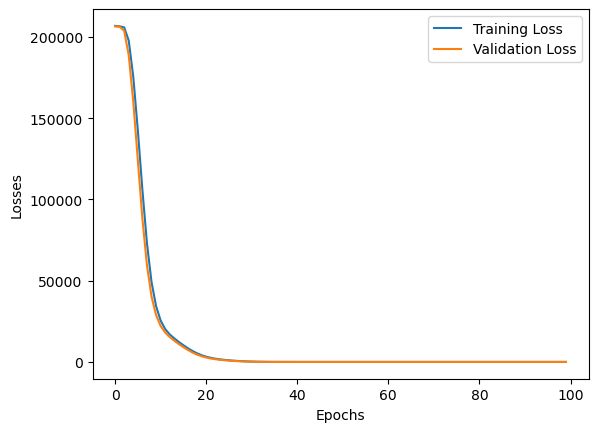

In [29]:
import matplotlib.pyplot as plt

loss_df = pd.DataFrame({
    "Training Loss": train_losses,
    "Validation Loss": val_losses
})

plt.plot(loss_df["Training Loss"], label = "Training Loss")
plt.plot(loss_df["Validation Loss"], label = "Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Losses")

plt.legend()

In [30]:
# Loading the best model
model.load_state_dict(torch.load("best_model.pt"))

# Evaluation

model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor)
    test_preds = model(X_test_tensor)

    train_mse_loss = crietrion(train_preds, y_train_tensor)
    test_mse_loss = crietrion(test_preds, y_test_tensor)

print("Training MSE:", train_mse_loss.item())
print("Testing MSE:", test_mse_loss.item())

from sklearn.metrics import r2_score

print("r^2 score =", r2_score(y_test, test_preds))

predicted_df = pd.DataFrame(test_preds.numpy(), columns=["Predicted Values"])
actual_df = pd.DataFrame(y_test.values, columns=["Actual Values"])

pd.concat([predicted_df, actual_df], axis=1)

Training MSE: 20.62970733642578
Testing MSE: 18.93981170654297
r^2 score = 0.9338102433006251


,Predicted Values,Actual Values
0,435.459717,433.27
1,436.926056,438.16
2,461.538757,458.42
3,476.447937,480.82
4,435.509491,441.41
...,...,...
1909,451.467957,456.70
1910,431.715149,438.04
1911,467.841492,467.80
1912,431.116302,437.14
